# Una modifica del modello SIR

Nel modello epidemiologico SIR, considerando la popolazione che si studia costante e di numerosità $N$, il diffondersi dell'epidemia è modellizzata dal sistema di equazioni differenziali

$$
\begin{cases}
\displaystyle
    S' = -\beta\frac{IS}{N}   \\
\displaystyle
    I' = \beta \frac{IS}{N} -\gamma I  \\
\displaystyle
    R' = \gamma I
\end{cases}
$$

dove $I$ è il numero di infetti, $R$ il numero di rimossi (cioè persone che hanno passato l'infezione e sono guarite, decedute o altro), $S$ il rimanente della popolazione.

I dati a disposizione durante una epidemia non consentono tuttavia di applicare questo modello in modo semplice: in particolare si dispone solitamente di:

- Il numero di persone per le quali si è verificato se sono contagiate o meno
- Il numero di persone trovate contagiate
- Il numero di persone decedute
- Il numero di persone guarite

Le persone sicuramente infette fanno parte del compartimento $I$, le persone decedute del comparimento $D$, le persone guarite del compartimento $G$, le persone risultate negative nel compartimento $O$, le rimanenti persone cui è stato fatto il test del compartimento $T$. Il resto della popolazione si considera nel compartimento $S$. In particolare

$$
    S = N - T, \qquad T = I + D + G + O
$$

La dinamica può avvenire in questo modo:

- Da $S$ si passa in $T$
- Da $O$ si passa a $I$
- Da $I$ si passa a $R=D+G$

Le equazioni che descrivono questa dinamica sono

$$
\begin{cases}
\displaystyle
    T' = \alpha\frac{T(N-T)}{N}   \\
\displaystyle
    I' = \beta \frac{I(T-R-I)}{T} -\gamma I  \\
\displaystyle
    R' = \gamma I   \\
\end{cases}
$$

Cominciamo con l'importare il dataset che contiene questi dati

In [44]:
import git
import json
import os
import shutil
import tempfile

tempdir = tempfile.mkdtemp()
repo = git.Repo.clone_from('https://github.com/pcm-dpc/COVID-19', tempdir, branch='master', depth=1)
with open(os.path.join(tempdir, 'dati-json','dpc-covid19-ita-andamento-nazionale.json')) as f:
    DATA = json.load(f)
try:
    shutil.rmtree(tempdir)
except:
    # potrebbero esserci problemi di permessi... alla peggio la cartella viene cancellata dall'OS
    pass

# Estraggo le serie storiche di interesse
serie_T = [i["tamponi"] for i in DATA]
serie_I = [i["totale_attualmente_positivi"] for i in DATA]
serie_D = [i["deceduti"] for i in DATA]
serie_G = [i["dimessi_guariti"] for i in DATA]
serie_R = [i["dimessi_guariti"]+i["deceduti"] for i in DATA]

Ora calibriamo il modello su questa serie storica per ottenere i valori ottimali di $\alpha$, $\beta$, $\gamma$ e $\delta$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fmin

# La funzione seguente torna un array con le curve T, I, D, G calcolate nei punti
# dell'intervallo, a partire dalle serie storiche e su beta e gamma ottimizzati
def Modello(N, T, I, R, intervallo, verbose=True):
    serie = np.array([[T[i], I[i], R[i]] for i in range(len(T))])
    serie0 = serie[0]
    
    # Calibriamo per t0 = 0, t1 = lunghezza serie - 1
    intervallo_dati = np.arange(len(T))
    
    def f(y, t, alpha, beta, gamma):
        # y = [T(t), I(t), R(t)]
        return [alpha*y[0]*(N-y[0])/N,
                beta*(y[0]-y[1]-y[2])*y[1]/y[0]-gamma*y[1],
                gamma*y[1]
               ]
    
    def modello(parametri):
        # Risolve il sistema di equazioni
        y = odeint(f, serie0, intervallo_dati, args=tuple(parametri))
        return np.linalg.norm(y - serie)

    # Trova il valore ottimale di beta e gamma e delta
    valori_ottimali = fmin(modello, (0.1, 0.1, 0.1), disp = False)   # valori iniziali dei paramatri

    if verbose:
        print("alpha ottimale =", valori_ottimali[0])
        print("beta ottimale =", valori_ottimali[1])
        print("gamma ottimale =", valori_ottimali[2])

    return odeint(f, serie0, intervallo, args=tuple(valori_ottimali))

# Ora disegna la soluzione per i valori ottimali ottimale
intervallo = np.arange(180)
y = Modello(2e6, serie_T, serie_I, serie_R, intervallo)

def grafico(handle, intervallo, dati, curva, titolo):
    handle.plot(intervallo[:len(dati)], dati, 'ro', label=f"Dati reali")
    handle.plot(intervallo, curva, label=f"Modello")
    handle.grid()
    handle.set_title(titolo)

fig, axes = plt.subplots(2, 2, figsize=(10, 5)) #, sharex='all', sharey='all')
fig.tight_layout(pad=3.0)
grafico(axes[0,0], intervallo, serie_T, y[:,0], "T")
grafico(axes[0,1], intervallo, serie_I, y[:,1], "I")
grafico(axes[1,0], intervallo, serie_R, y[:,2], "G")
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles=handles,   # The line objects
           labels=labels,     # The labels for each line
           loc="lower left",  # Position of legend
           borderaxespad=0.1, # Small spacing around legend box
           )


NameError: name 'serie_T' is not defined

Provo una ottimizzazione con un modello stupido: suppongo che I sia sviluppata in serie di Fourier

$$
    I(t) = I_0 + a_1\cos(t) + b_1\sin(t) + a_2\cos(2t) +b_2\sin(2t) + ...
$$


a1 = -57803.34378767423
b1 = -0.012839690979280659
a2 = 0.12081744182008833
b2 = 0.08510227455227903


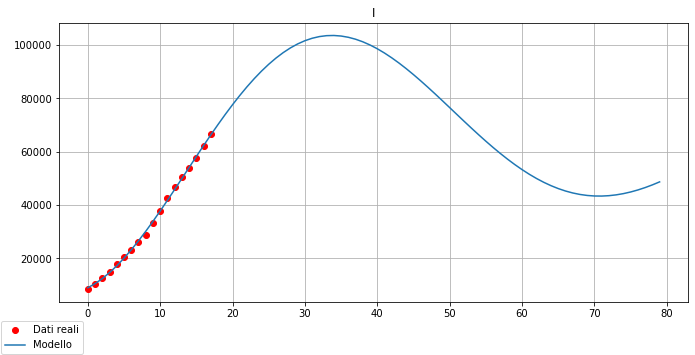

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fmin

serie_I = serie_I[15:]

# La funzione seguente torna un array con le curve T, I, D, G calcolate nei punti
# dell'intervallo, a partire dalle serie storiche e su beta e gamma ottimizzati
def Modello(I, delta_x, verbose=True):
    I0 = I[-1]
    # Calibriamo per t0 = 0, t1 = lunghezza serie - 1
    data_x = np.arange(len(I))
    
    def f(x, p):
        return I0 + p[0]*np.exp(p[1]*x)*np.cos(p[2]+p[3]*x)
    
    def modello(p):
        return np.linalg.norm(f(data_x, p) - I)

    # Trova il valore ottimale di beta e gamma e delta
    p = fmin(modello, (I0/2,1,0,1), disp = False)   # valori iniziali dei paramatri

    if verbose:
        print("a1 =", p[0])
        print("b1 =", p[1])
        print("a2 =", p[2])
        print("b2 =", p[3])

    return f(delta_x, p)

# Ora disegna la soluzione per i valori ottimali ottimale
intervallo = np.arange(80)
y = Modello(serie_I, intervallo)

def grafico(handle, intervallo, dati, curva, titolo):
    handle.plot(intervallo[:len(dati)], dati, 'ro', label=f"Dati reali")
    handle.plot(intervallo, curva, label=f"Modello")
    handle.grid()
    handle.set_title(titolo)

fig, axes = plt.subplots(1, 1, figsize=(10, 5)) #, sharex='all', sharey='all')
fig.tight_layout(pad=3.0)
grafico(axes, intervallo, serie_I, y, "I")
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles=handles,   # The line objects
           labels=labels,     # The labels for each line
           loc="lower left",  # Position of legend
           borderaxespad=0.1, # Small spacing around legend box
           )
plt.show("fake.png")

In [38]:
serie_I

[20603,
 23073,
 26062,
 28710,
 33190,
 37860,
 42681,
 46638,
 50418,
 54030,
 57521,
 62013]